In [2]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [3]:
!kaggle datasets download -d praveengovi/emotions-dataset-for-nlp

Dataset URL: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp
License(s): CC-BY-SA-4.0
  0% 0.00/721k [00:00<?, ?B/s]
100% 721k/721k [00:00<00:00, 138MB/s]


In [4]:
! unzip "emotions-dataset-for-nlp.zip"

Archive:  emotions-dataset-for-nlp.zip
  inflating: test.txt                
  inflating: train.txt               
  inflating: val.txt                 


In [9]:
!pip install pandas fasttext nltk -q

In [18]:
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Text Preprocessing

In [24]:
from preprocessing import preprocess_text

In [27]:
import pandas as pd
import fasttext

def load_and_save_data(file):
  df = pd.read_csv(file , delimiter=";", header=None, names=["text", "emotion"])
  df['preprocessed_text'] = df['text'].apply(preprocess_text)
  df['label'] = df.apply(lambda row: f"__label__{row['emotion']} {row['preprocessed_text']}", axis=1)
  df['label'].to_csv(file, index=False, header=False)
  return df


train = load_and_save_data("train.txt")
test = load_and_save_data("test.txt")
val = load_and_save_data("val.txt")

In this study, the pre-trained fastText model was trained for 8 epochs
 on the 80% training data with a learning rate of 0.7 and the number
 of wordgrams as 4. The loss function used was one-versus-all, for
 efficient multi-class classification.This loss function creates 6 different
 binary classification models for each of the 6 classes and trains each
 with respect to all others.

In [33]:
model = fasttext.train_supervised(
    input="train.txt",
    lr=0.7,
    epoch=8,
    wordNgrams=4,
    loss="ova",
)

In [37]:
result = model.test("test.txt")

print(f"Number of examples: {result[0]}")
print(f"Precision at 1: {result[1]}")
print(f"Recall at 1: {result[2]}")

val_result = model.test("_val.txt")
print(f"Validation Precision: {val_result[1]}")
print(f"Validation Recall: {val_result[2]}")

Number of examples: 2000
Precision at 1: 0.8895
Recall at 1: 0.8895
Validation Precision: 0.89
Validation Recall: 0.89


In [43]:
import fasttext
import matplotlib.pyplot as plt

best_accuracy = 0
best_model = None

precisions = []
recalls = []

for epoch in range(1, 20):
    model = fasttext.train_supervised(
        input="train.txt",
        lr=0.7,
        epoch=epoch,
        wordNgrams=4,
        loss="ova"
    )

    result = model.test("val.txt")
    precision, recall = result[1], result[2]

    precisions.append(precision)
    recalls.append(recall)

    print(f"Epoch {epoch}: Precision={precision}, Recall={recall}", end = ' - ')

    if precision > best_accuracy:
        best_accuracy = precision
        best_model = model
        model.save_model("best_model.bin")
        print("Saved model")
    else:
      print()

Epoch 1: Precision=0.7175, Recall=0.7175 - Saved model
Epoch 2: Precision=0.8795, Recall=0.8795 - Saved model
Epoch 3: Precision=0.891, Recall=0.891 - Saved model
Epoch 4: Precision=0.8965, Recall=0.8965 - Saved model
Epoch 5: Precision=0.893, Recall=0.893 - 
Epoch 6: Precision=0.892, Recall=0.892 - 
Epoch 7: Precision=0.8915, Recall=0.8915 - 
Epoch 8: Precision=0.89, Recall=0.89 - 
Epoch 9: Precision=0.891, Recall=0.891 - 
Epoch 10: Precision=0.8935, Recall=0.8935 - 
Epoch 11: Precision=0.89, Recall=0.89 - 
Epoch 12: Precision=0.8905, Recall=0.8905 - 
Epoch 13: Precision=0.8905, Recall=0.8905 - 
Epoch 14: Precision=0.8905, Recall=0.8905 - 
Epoch 15: Precision=0.8905, Recall=0.8905 - 
Epoch 16: Precision=0.89, Recall=0.89 - 
Epoch 17: Precision=0.8895, Recall=0.8895 - 
Epoch 18: Precision=0.8895, Recall=0.8895 - 
Epoch 19: Precision=0.8885, Recall=0.8885 - 


As you can see, the best accuracy was obtained at Epoch 4 , whereas the paper used 8 epochs.

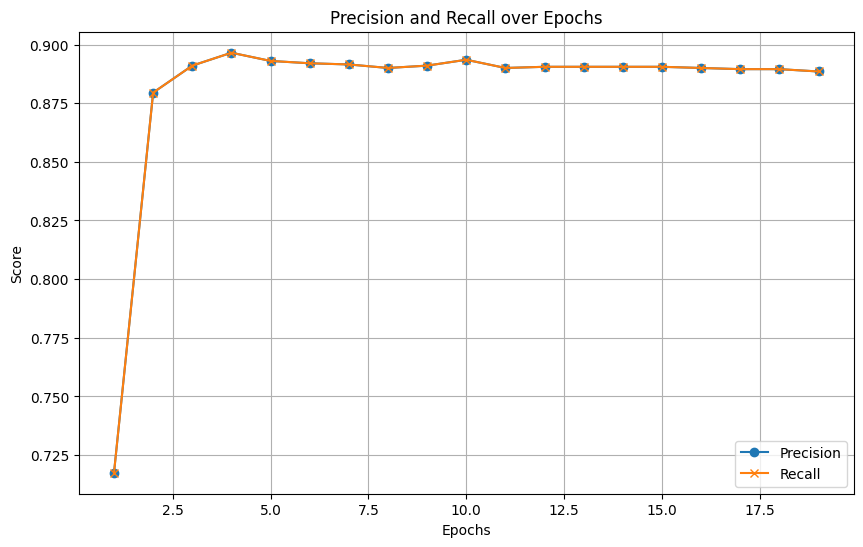

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), precisions, label='Precision', marker='o')
plt.plot(range(1, 20), recalls, label='Recall', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Precision and Recall over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('precision_recall_plot.png')
plt.show()